In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np

import sys
import os

import matplotlib.colors as cols
import matplotlib.pyplot as plt

from matplotlib import colormaps
from matplotlib.gridspec import GridSpec
# change the default resolution
# for better looking plots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

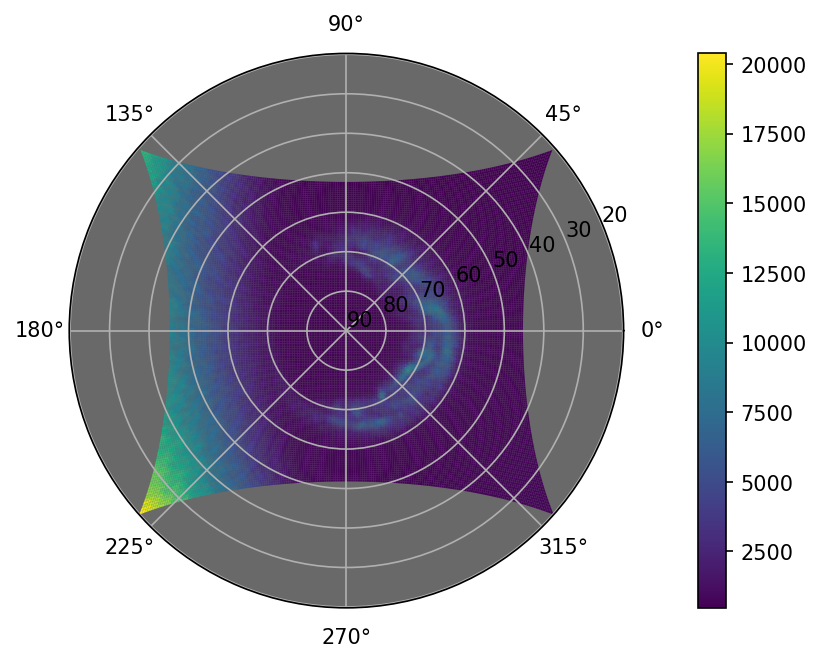

In [4]:
#add read_io module to current path ()
file_path = 'D:\\GitHub\\DataIO\\'
sys.path.append(os.path.dirname(file_path))

import data_io
import data_io.plotting as dpl

In [5]:
orb_omni = r'E:/Data/IMAGE/image_orb_omni.hdf'

orb = pd.read_hdf(orb_omni)

In [6]:
orb['z_angle'] = np.rad2deg(np.arctan2(np.sqrt(orb['X-GSM']**2+orb['Y-GSM']**2),orb['Z-GSM']))

<Axes: xlabel='DateTime'>

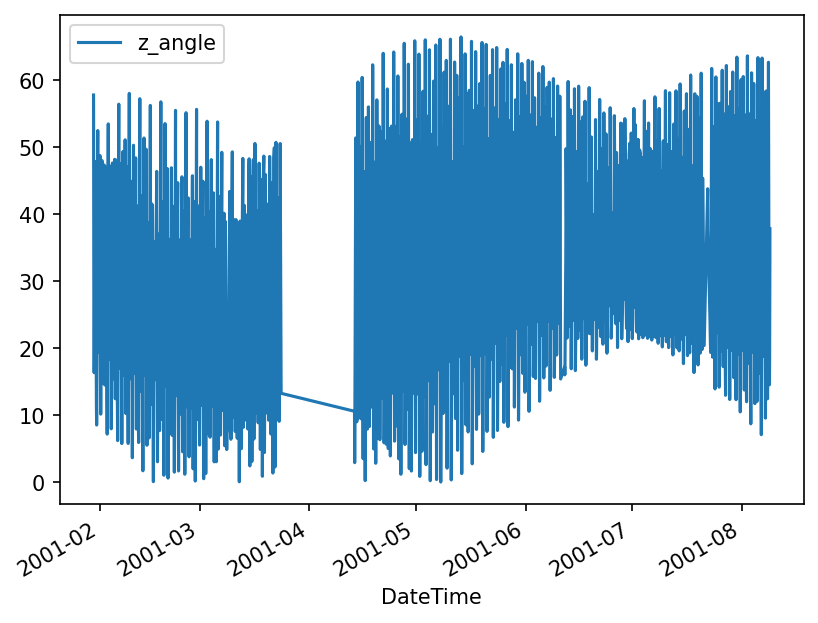

In [7]:
orb.plot(y='z_angle')

In [8]:
gd = (orb['z_angle'] < 10) & (orb['Bz_GSM'] < -4) & (orb['Bz_GSM'] > -6)

In [9]:
fn = orb.loc[gd,'filename'].to_list()

In [10]:
d = data_io.image.load_image_guvi(files=fn,local_dir='E:/Data/IMAGE/',grid=True)

(<PolarAxes: >,
 <matplotlib.colorbar.Colorbar at 0x1fa32f17760>)

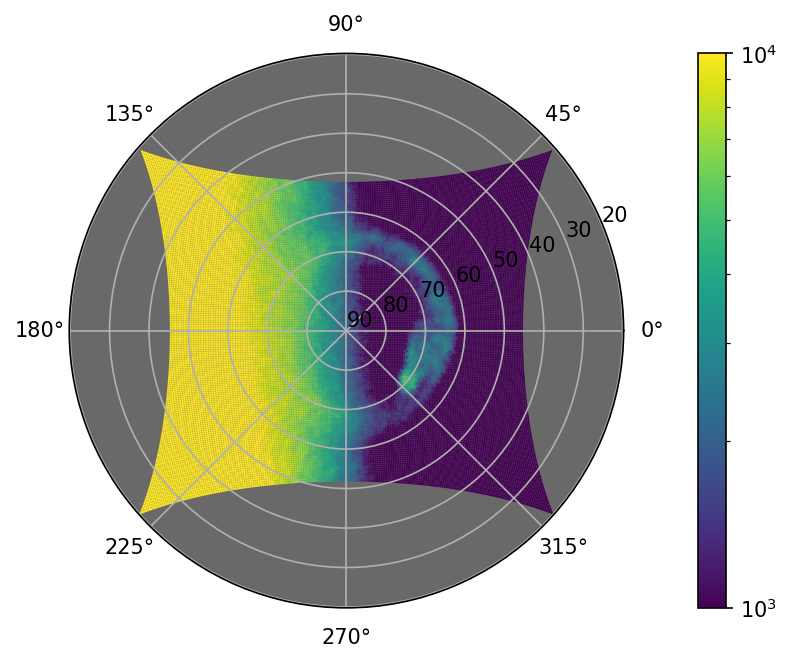

In [19]:
im = d['IM']
norm = cols.LogNorm(vmin=1000,vmax=10000)
dpl.guvi_plot(im[100,:,:].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm)

In [ ]:
# generate some images

InteractiveShell.ast_node_interactivity = "all"
norm = cols.LogNorm()
cmap = mpl.colormaps['inferno']

for i, im_p in zip(np.arange(im.shape[0]),im):
    dt = d['DateTime'][i] 
    plt.imshow(im_p[50:-20,y_arg], norm=norm,cmap=cmap)
    plt.title(f'{dt} -  {i:04}')
    plt.savefig(f'E:/Data/IMAGE/plots/{i:04}.png', bbox_inches='tight')




In [11]:
from scipy.optimize import curve_fit 
def gfit(x, A0, A1, A2, A3, A4):

    z = (x-A1)/A2

    return A0*np.exp(-0.5*(z**2)) + A3 + A4*x

def gfit_ns(x, A0, A1, A2, A3):

    z = (x-A1)/A2

    return A0*np.exp(-0.5*(z**2)) + A3

In [13]:
i_st = 152
i_en = 165

op = False

lat_c = list()
lon_c = list()
x_c = list()
y_c = list()
sig = list()
hgt = list()
cnt = list()
bas = list()

scn=0
jump=True
while scn < d['LAT_ARR'][0].shape[1]:
#for scn in np.arange(2):
    lats = d['LAT_ARR'][i_st][:,scn]
    lons = d['LON_ARR'][i_st][:,scn]

    scn_i = d['IM'][i_st][:,scn]
    scn_m = d['MLT_ARR'][i_st][:,scn]
    scn_x = (90-lats)*np.cos(np.deg2rad(lons))

    gd = np.where(scn_x > 0)

    g0 = scn_i[gd].max()-scn_i[gd].min()
    g1 = lats[gd[0][scn_i[gd].argmax()]]
    g2 = 5
    g3 = scn_i[gd].min()
    g4 = 0

    p, covariance = curve_fit(gfit_ns, lats[gd], scn_i[gd],p0=[g0,g1,g2,g3]) 
    
    p_bnd = p[1]+2*p[2]

    if p_bnd > lats[gd].max():
        if jump:
            jump=False
            # need to figure our which scan to jump to 
            # 
            mlt_nxt = d['MLT_ARR'][i_st][gd[0][10],scn:]
            scn = np.nanargmin(mlt_nxt)+scn 
            continue
        else:
            break

    if op:
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(5, 2))
        ax[0].plot(lats[gd],scn_i[gd])
        ax[0].plot(lats[gd],gfit_ns(lats[gd],p[0],p[1],p[2],p[3]))
        ax[1].imshow(d['IM'][i_st])
        ax[1].plot([scn,scn],[0,scn_x.shape[0]], color='red')
        plt.show()


    # find closest point from array
    pk_id = np.abs(lats[gd]-p[1]).argmin()

    lat_c.append(lats[gd[0][pk_id]])
    lon_c.append(lons[gd[0][pk_id]])

    x_c.append(scn)
    y_c.append(gd[0][pk_id])
    hgt.append(p[0])
    cnt.append(p[1])
    sig.append(p[2])
    bas.append(p[3])

    scn += 1




In [14]:
op=False
scn=0
jump=True


for scn, ht, ct, sg, bs in zip(x_c, hgt,cnt, sig, bas):
#for scn in np.arange(2):
    lats = d['LAT_ARR'][i_st][:,scn]
    lons = d['LON_ARR'][i_st][:,scn]

    scn_i = d['IM'][i_st][:,scn]
    scn_m = d['MLT_ARR'][i_st][:,scn]
    scn_x = (90-lats)*np.cos(np.deg2rad(lons))

    gd = np.where(scn_x < 0)

    g0 = ht
    g1 = ct
    g2 = sg
    g3 = bs
    g4 = 0

    gd = np.where((scn_x < 0) & (lats > (g1-5)) & (lats < (g1+20)))

    try:
        p, covariance = curve_fit(gfit, lats[gd], scn_i[gd],p0=[g0,g1,g2,g3,g4]) 
    except:
        continue

    if p[0] < 1000 or p[1]+3*p[2] > lats[gd].max() or p[1]-3*p[2] < lats[gd].min() or p[2] < 0:
        continue
    # find closest point from array
    pk_id = np.abs(lats[gd]-p[1]).argmin()

    lat_c.append(lats[gd[0][pk_id]])
    lon_c.append(lons[gd[0][pk_id]])
    sig.append(p[2])
    x_c.append(scn)
    y_c.append(gd[0][pk_id])

    if op:
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(5, 2))
        ax[0].plot(lats[gd],scn_i[gd])
        ax[0].plot(lats[gd],gfit(lats[gd],p[0],p[1],p[2],p[3], p[4]))
        ax[0].set_title(f'{scn}')
        ax[1].imshow(d['IM'][i_st])
        ax[1].plot([scn,scn],[0,scn_x.shape[0]], color='red')
        ax[1].scatter(scn,gd[0][pk_id])
        plt.show()


    

c:\Users\murph\miniconda3\envs\satdrag\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


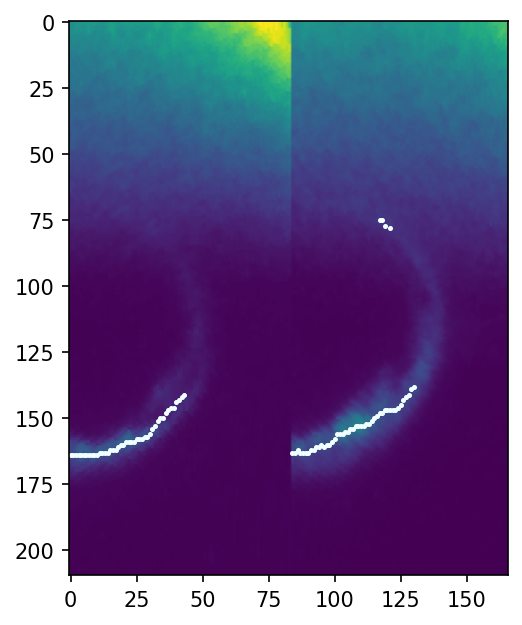

In [16]:
fig, ax = plt.subplots()

ax.imshow(d['IM'][i_st])
ax.scatter(x_c,y_c,2, color='azure')


In [17]:
def compute_a(points):
  n = len(points)
  value = np.ones((n, 3))
  for i in range(n):
    x, y = points[i]
    value[i, 0] = -2*x
    value[i, 1] = -2*y
  return value

def fit_circle(points):
  A = compute_a(Xf)
  Y = np.sum(np.square(Xf), axis=-1)
  Y = -Y
  a, b, k = (np.linalg.inv(A.T @ A) @ A.T) @ Y

  r = np.sqrt(a**2 + b**2 - k)

  return r, a, b


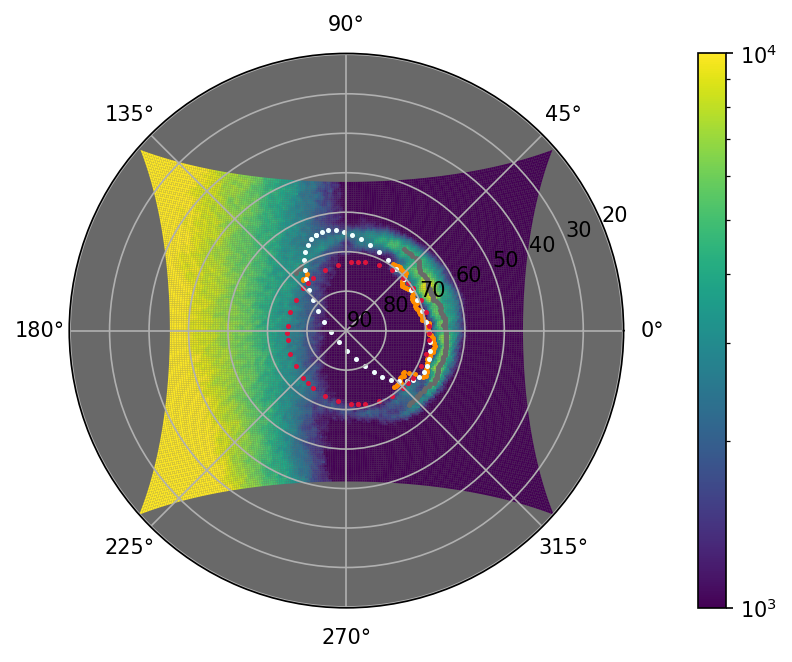

In [21]:
from ellipse import LsqEllipse

# convert to cartesian for fitting
# and add to single array
x = (90-(np.array(lat_c)+2*np.array(sig)))*np.cos(np.deg2rad(lon_c))
y = (90-(np.array(lat_c)+2*np.array(sig)))*np.sin(np.deg2rad(lon_c))

# construct array of points
Xf = np.array(list(zip(x, y)))

# fit a circle
c_fit = fit_circle(Xf)
circ = plt.Circle((c_fit[1], c_fit[2]), c_fit[0], color='r', fill=False).get_verts()
clon = np.arctan2(circ[:,1],circ[:,0])
clat = 90-np.sqrt(circ[:,0]**2+circ[:,1]**2)

# fit an ellipse
ell = LsqEllipse().fit(Xf)
e_c, sx, sy, e_a = ell.as_parameters()

e_a = e_a*-1
# derive ellipse use 2 degree spacing
vv = ell.return_fit(45)
vlat = 90-np.sqrt(vv[:,0]**2+vv[:,1]**2)
vlon = np.arctan2(vv[:,1],vv[:,0])

ax, p_col, c_bar = dpl.guvi_plot(d['IM'][i_st].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm)
ax.scatter(np.deg2rad(lon_c),lat_c,2, label='Center of Arc', color='dimgrey')
ax.scatter(np.deg2rad(lon_c),lat_c+2*np.array(sig),2, label='Poleward Edge', color='darkorange')
ax.scatter(vlon,vlat,2, label='Ellipse Fit', color='azure')
ax.scatter(clon, clat, 2, label='Circle Fit', color='crimson' )



# How does the fit change with fewer slices? 

In [183]:
# lets only look at scans in a specific region from dawn to dusk
# -30 < y < 30
n=2

lat_v = d['LAT_ARR'][i_st][104,::n].copy()
lon_v = d['LON_ARR'][i_st][104,::n].copy()

y_v = (90-(np.array(lat_v)))*np.sin(np.deg2rad(lon_v))
y_gd = np.where((y_v > 20) & (y_v < 35))

print(f'Number of scans between [-30,30] dawn to dusk: {y_gd[0].shape[0]}')
print(f'Total Scans: {y_v.shape[0]}')

Number of scans between [-30,30] dawn to dusk: 16
Total Scans: 83


Lets take every second, third, fourth, fifth and sixth scan and see how things change

In [23]:
len(lon_c)
len(lat_c)
len(sig)

95

95

95

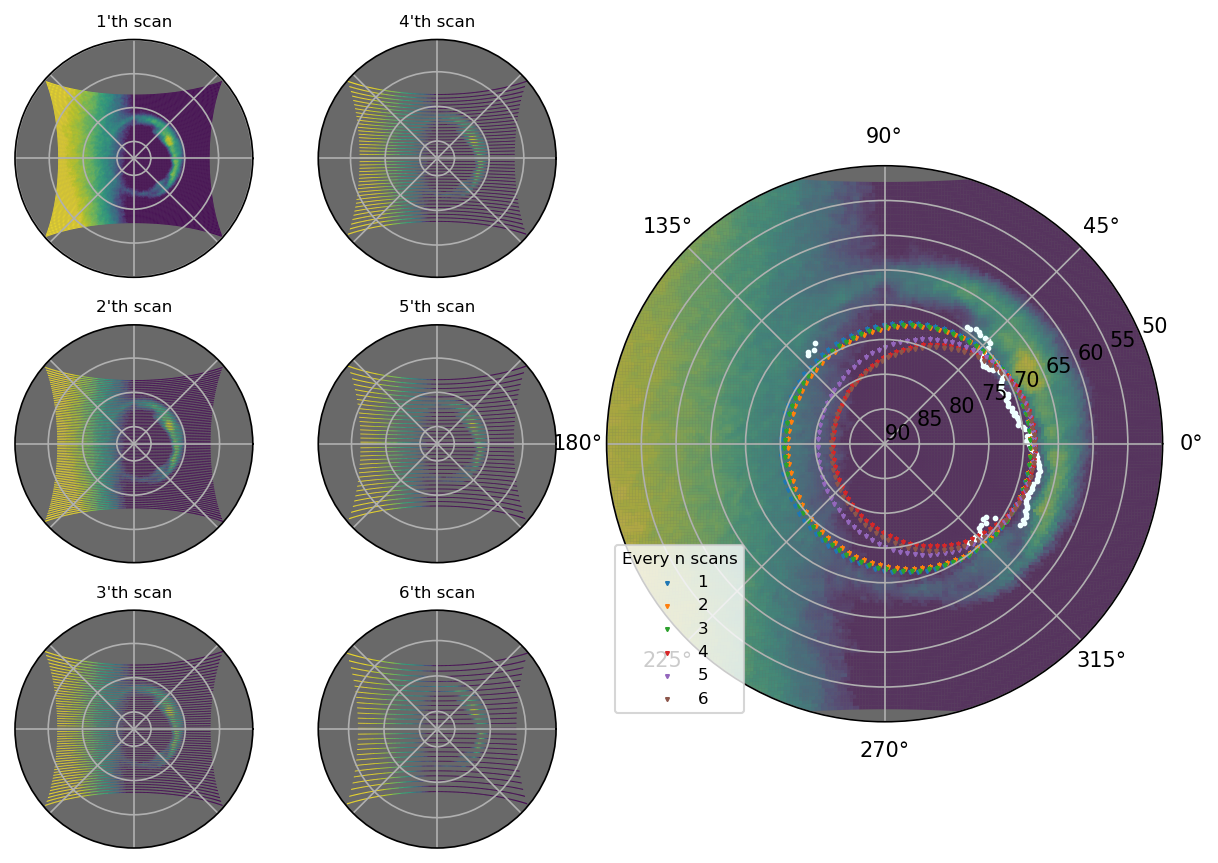

In [24]:
fig = plt.figure(figsize=[10,7])

gs = GridSpec(3,4)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])

ax7 = fig.add_subplot(gs[:,2:],projection='polar')

axes = fig.axes[:-1]

n = [1,2,3,4,5,6]

lat_c = np.array(lat_c)
lon_c = np.array(lon_c)
sig = np.array(sig)

xp = (90-(lat_c+2*sig))*np.cos(np.deg2rad(lon_c))
yp = (90-(lat_c+2*sig))*np.sin(np.deg2rad(lon_c))
scans = np.arange(0,d['IM'].shape[2])


ax7, _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm,ax=ax7,alpha=0.5)
cb.remove()
_ = ax7.set_rlim(90,50)
_ = ax7.scatter(np.deg2rad(lon_c),lat_c+2*sig,3,color='azure')


for ns, axp in zip(n,axes):
    idx = [i for i, lv in enumerate(x_c) for scn_i in scans[::ns] if lv == scn_i]

    x = (90-(lat_c[idx]+2*sig[idx]))*np.cos(np.deg2rad(lon_c[idx]))
    y = (90-(lat_c[idx]+2*sig[idx]))*np.sin(np.deg2rad(lon_c[idx]))

    # construct array of points
    Xf = np.array(list(zip(x, y)))

    # fit a circle
    c_fit = fit_circle(Xf)

    rad = 2*np.pi*np.arange(0,90)/90.

    x_circ = c_fit[1]+c_fit[0]*np.cos(rad)
    y_circ = c_fit[2]+c_fit[0]*np.sin(rad)

    clon = np.arctan2(y_circ,x_circ)
    clat = 90-np.sqrt(y_circ**2+x_circ**2)

    r = np.hypot(x_circ, y_circ)
    th = np.degrees(np.arctan2(y_circ, x_circ))

    #ax1.scatter(x,y,4, )
    #ax1.scatter(x_circ, y_circ,4, marker='v',label=f'{ns}')
    _ = ax7.scatter(clon,clat,2, marker='v',label=f'{ns}')

    axp , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::ns],d['LAT_VERTS'][:,::ns],d['LON_VERTS'][:,::ns],norm=norm,ax=axp)
    cb.remove()
    _ = axp.set_yticklabels([])
    _ = axp.set_xticklabels([])
    _ = axp.set_title(f"{ns}'th scan", fontsize=8)
    
#ax1.scatter(xp,yp,4,color='grey',label='Data')   

ax7.legend(loc=3,fontsize=8,title='Every n scans',title_fontsize=8)


In [25]:
y_gd[0].shape

(78,)

In [26]:
im_par = d['IM'][i_st][:,y_gd[0]].squeeze()

im_par.shape

im_par[:,::2]

(210, 78)

array([[10584.884  , 11307.668  , 11189.733  , ..., 20685.412  ,
        20595.959  , 20153.26   ],
       [10584.884  , 11222.744  , 11189.733  , ..., 20685.412  ,
        20595.959  , 20153.26   ],
       [10491.337  , 11222.744  , 11205.753  , ..., 20685.412  ,
        20291.955  , 20373.676  ],
       ...,
       [  520.065  ,   550.3812 ,   556.9037 , ...,   546.978  ,
          576.42395,   569.6795 ],
       [  520.065  ,   513.9383 ,   556.9037 , ...,   546.978  ,
          576.42395,   569.6795 ],
       [  511.56107,   513.9383 ,   509.5399 , ...,   546.978  ,
          576.42395,   569.6795 ]], dtype=float32)

In [27]:
op = False
n = [1,2,3,4,5,6]

#n = [6]

mlt_bn = 0.25
mlt_val = np.array([np.arange(0,12,mlt_bn),np.arange(12,24,mlt_bn)[::-1]]).flatten() 

dat = dict()

lat_v = d['LAT_ARR'][i_st][104,::1].copy()
lon_v = d['LON_ARR'][i_st][104,::1].copy()

y_v = (90-(np.array(lat_v)))*np.sin(np.deg2rad(lon_v))
y_gd = np.where((y_v > -35) & (y_v < 35))

for ns in n:

    mlt_bn = 0.25 if ns < 5 else 0.5
    mlt_val = np.array([np.arange(0,12,mlt_bn),np.arange(12,24,mlt_bn)[::-1]]).flatten() 

    im_par = d['IM'][i_st][:,y_gd].squeeze()
    lat_par = d['LAT_ARR'][i_st][:,y_gd].squeeze()
    lon_par = d['LON_ARR'][i_st][:,y_gd].squeeze()
    mlt_par = d['MLT_ARR'][i_st][:,y_gd].squeeze()

    im_par = im_par[:,::ns]
    lat_par = lat_par[:,::ns]
    lon_par = lon_par[:,::ns]
    mlt_par = mlt_par[:,::ns]

    im_par.shape

    lat_bn_c = list()
    sig_bn = list()
    lon_bn_c = list()
    mlt_bn_c = list()

    jump=False


    for mlt_st in mlt_val:
        if op:
            print(f'Starting: {mlt_st:05.2f} - {mlt_st+mlt_bn:05.2f}')
        gd = np.where((mlt_par>=mlt_st) & (mlt_par<(mlt_st+mlt_bn)))

        lat_f = lat_par[gd]
        lon_f = lon_par[gd]
        im_f = im_par[gd]

        gd_l = np.where(lat_f > 50)

        if mlt_st == 0 or jump:
            g0 = im_f[gd_l].max()-im_f[gd_l].min()
            g1 = lat_f[im_f[gd_l].argmax()]
            g2 = 5
            g3 = im_f[gd_l].min()
            g4 = 0
        else:
            g0 = p[0]
            g1 = p[1]
            g2 = p[2]
            g3 = p[3]
            g4 = p[4]

           

        try:
            p, covariance = curve_fit(gfit, lat_f[gd_l], im_f[gd_l],p0=[g0,g1,g2,g3,g4])
            jump = False
        except:
            if op:
                print(f'Skipping: {mlt_st:05.2f} - {mlt_st+mlt_bn:05.2f}')
            jump = True
            continue

        if p[0] < 500 or p[1]+3*p[2] > lat_f[gd_l].max() or p[1]-3*p[2] < lat_f[gd_l].min() or p[2] < 0:
            if op:
                print(f'Skipping bad fit: {p[0]}, {p[1]+3*p[2]}, {p[1]-3*p[2]}')
            jump=True
            continue

        if op:
            fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5, 2))
            _ = ax.scatter(lat_f, im_f,2)
            _ = ax.scatter(lat_f,gfit(lat_f,p[0],p[1],p[2],p[3],p[4]),2)
            _ = ax.set_title(f'{mlt_st:05.2f} - {mlt_st+mlt_bn:05.2f}')
            #plt.show()

        lat_bn_c.append(p[1])
        sig_bn.append(p[2])
        lon_bn_c.append(lon_f[gd_l].mean())
        mlt_bn_c.append(mlt_st+mlt_bn/2.)

    fit_dic = {'lats':np.array(lat_bn_c), 'sigma':np.array(sig_bn), 'lons':np.array(lon_bn_c), 'mlts':np.array(mlt_bn_c)}
    dat[ns] = fit_dic


(210, 155)

c:\Users\murph\miniconda3\envs\satdrag\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(210, 78)

(210, 52)

(210, 39)

(210, 31)

(210, 26)

(90.0, 55.0)

(90.0, 55.0)

(90.0, 55.0)

(69,) , (69,)


(90.0, 55.0)

(69,) , (69,)


(90.0, 55.0)

(68,) , (68,)


(90.0, 55.0)

(68,) , (68,)


(90.0, 55.0)

(34,) , (34,)


(90.0, 55.0)

(36,) , (36,)


(90.0, 55.0)

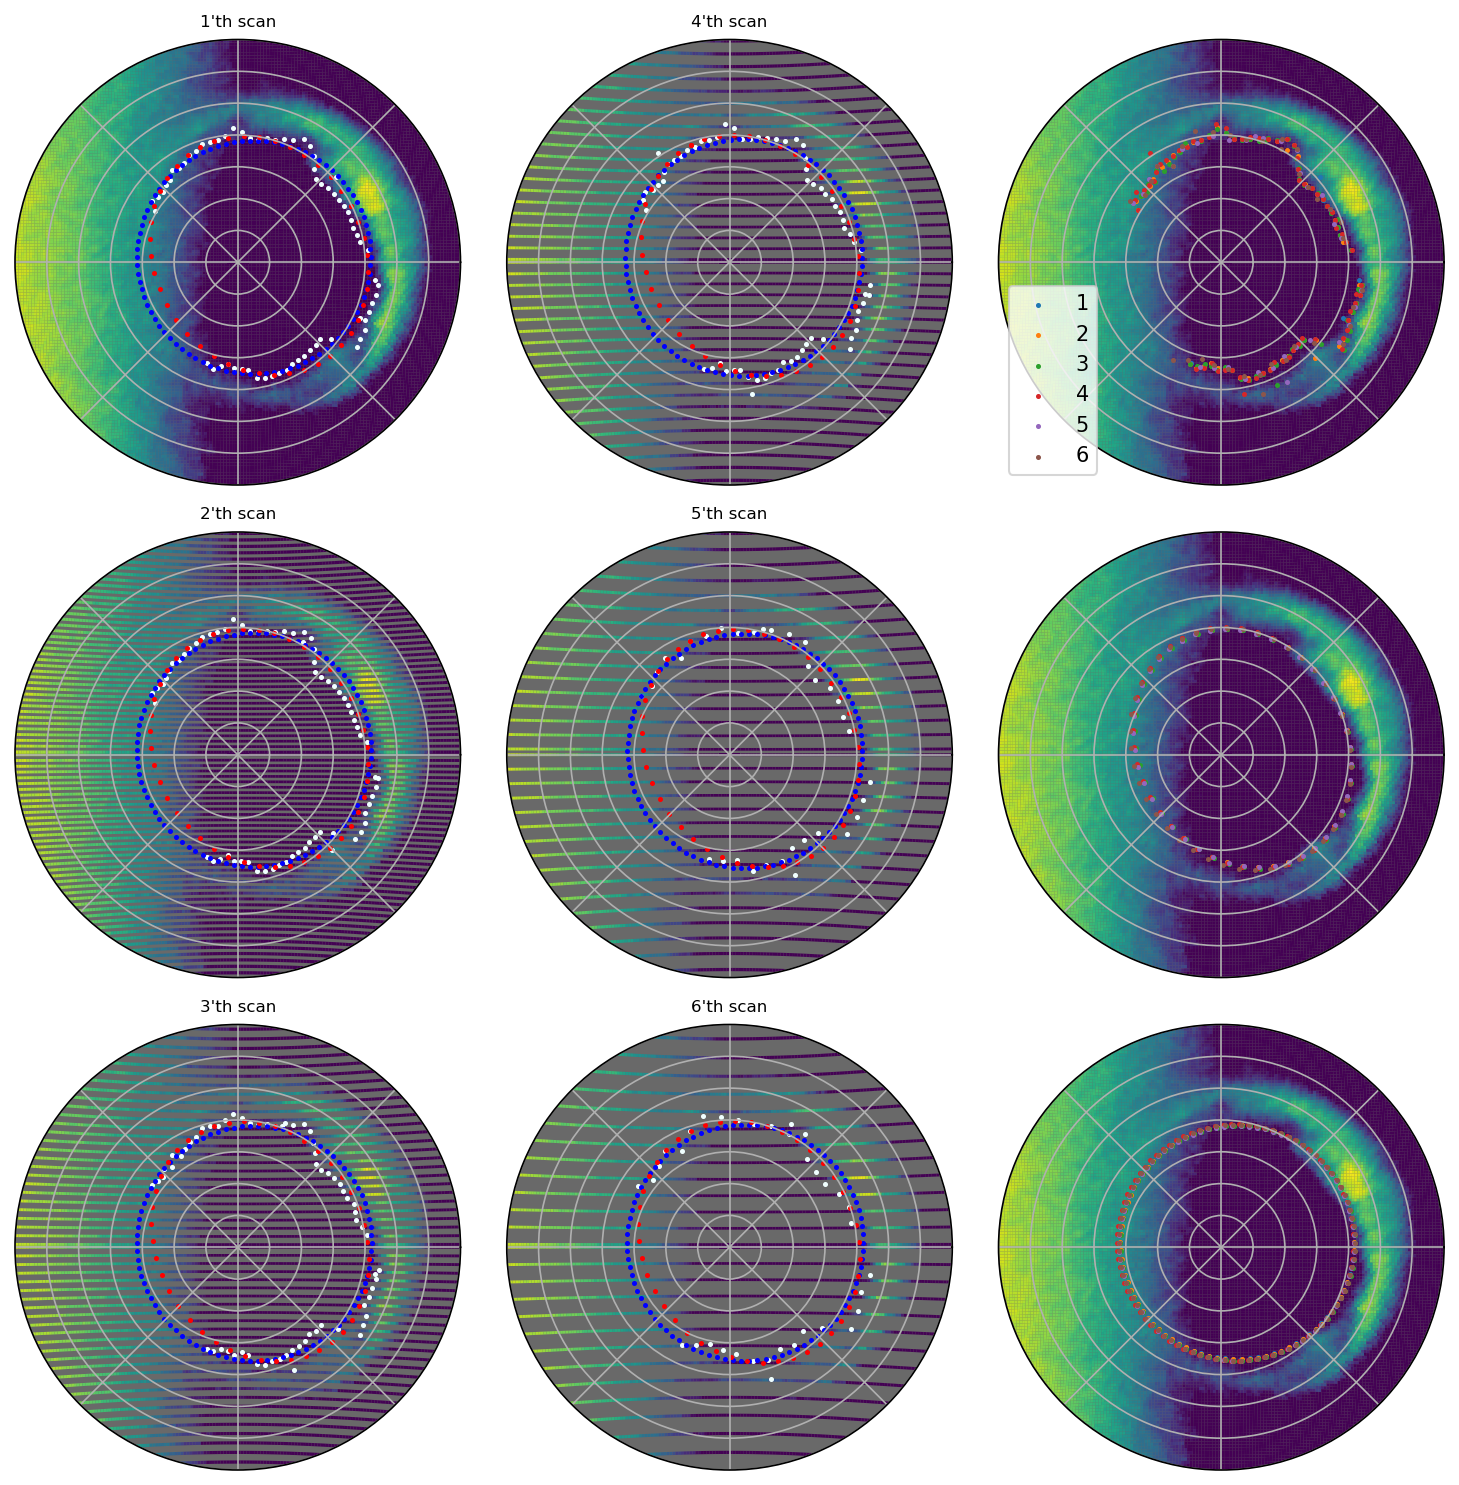

In [96]:
fig = plt.figure(figsize=[10,10])

gs = GridSpec(3,3)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])
ax7 = fig.add_subplot(gs[0,2],projection='polar')
ax8 = fig.add_subplot(gs[1,2],projection='polar')
ax9 = fig.add_subplot(gs[2,2],projection='polar')

axes = fig.get_axes()[:-1]

ax7 , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::1],d['LAT_VERTS'][:,::1],d['LON_VERTS'][:,::1],norm=norm, ax=ax7)
ax7.set_rlim(90,55)
cb.remove()
_ = ax7.set_yticklabels([])
_ = ax7.set_xticklabels([])
ax8 , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::1],d['LAT_VERTS'][:,::1],d['LON_VERTS'][:,::1],norm=norm, ax=ax8)
ax8.set_rlim(90,55)
cb.remove()
_ = ax8.set_yticklabels([])
_ = ax8.set_xticklabels([])
ax9 , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::1],d['LAT_VERTS'][:,::1],d['LON_VERTS'][:,::1],norm=norm, ax=ax9)
ax9.set_rlim(90,55)
cb.remove()
_ = ax9.set_yticklabels([])
_ = ax9.set_xticklabels([])
#axp.scatter(np.deg2rad(lon_bn_c),lat_bn_c,2, color='white')

for ks, axp in zip(dat.keys(),axes):

    lat_f = dat[ks]['lats']+2*dat[ks]['sigma']
    lon_f = np.deg2rad(dat[ks]['lons'])

    gd = np.where(lat_f > (lat_f.mean()-3*lat_f.std()))

    print(f'{gd[0].shape} , {lat_f.shape}')
    
    x = (90-lat_f[gd[0]])*np.cos(lon_f[gd[0]])
    y = (90-lat_f[gd[0]])*np.sin(lon_f[gd[0]])

    # construct array of points
    Xf = np.array(list(zip(x, y)))

    # fit a circle
    c_fit = fit_circle(Xf)

    rad = 2*np.pi*np.arange(0,90)/90.

    x_circ = c_fit[1]+c_fit[0]*np.cos(rad)
    y_circ = c_fit[2]+c_fit[0]*np.sin(rad)

    clon = np.arctan2(y_circ,x_circ)
    clat = 90-np.sqrt(y_circ**2+x_circ**2)

    # fit an ellipse
    e_fit = LsqEllipse().fit(Xf)

    # derive ellipse use 2 degree spacing
    vv = e_fit.return_fit(45)
    elat = 90-np.sqrt(vv[:,0]**2+vv[:,1]**2)
    elon = np.arctan2(vv[:,1],vv[:,0])

    axp, _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::ks],d['LAT_VERTS'][:,::ks],d['LON_VERTS'][:,::ks],norm=norm, ax=axp)
    axp.set_rlim(90,55)
    cb.remove()
    _ = axp.set_yticklabels([])
    _ = axp.set_xticklabels([])
    _ = axp.set_title(f"{ks}'th scan", fontsize=8)

    _ = axp.scatter(lon_f,lat_f,2, color='azure')
    _ = axp.scatter(clon, clat,2, color='blue')
    _ = axp.scatter(elon, elat,2, color='red')

    _ = ax7.scatter(lon_f,lat_f,2, label=f'{ks}')
    _ = ax8.scatter(elon,elat,2)
    _ = ax9.scatter(clon,clat,2)

    dat[ks]['cir_lat'] = clat
    dat[ks]['cir_lon'] = np.rad2deg(clon)

    dat[ks]['ell_lat'] = elat
    dat[ks]['ell_lon'] = np.rad2deg(elon)

ax7.legend(loc=3)
plt.tight_layout()                                                     

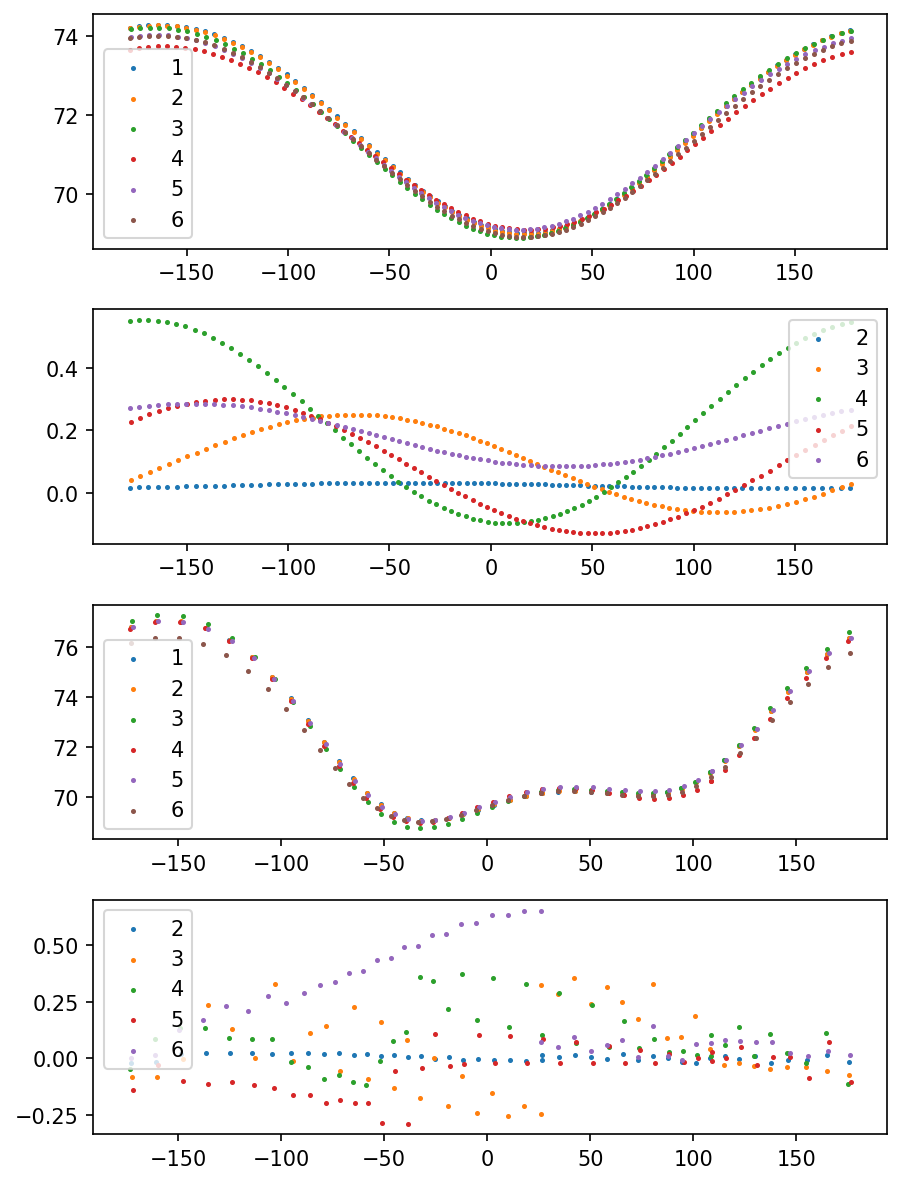

In [86]:
fig, ax = plt.subplots(4,1,figsize=[6,8])

for ks in dat.keys():
    _ = ax[0].scatter(dat[ks]['cir_lon'],dat[ks]['cir_lat'],2,label=f'{ks}')
    _ = ax[2].scatter(dat[ks]['ell_lon'],dat[ks]['ell_lat'],2,label=f'{ks}')

    if ks !=1:
        _ = ax[1].scatter(dat[ks]['cir_lon'],dat[1]['cir_lat']-dat[ks]['cir_lat'],2,label=f'{ks}')
        _ = ax[3].scatter(dat[ks]['ell_lon'],np.sort(dat[1]['ell_lat'])-np.sort(dat[ks]['ell_lat']),2,label=f'{ks}')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.tight_layout() 

### Let's Compare the full image with every 4rth scan image.

In [40]:
dat[1].keys()

dict_keys(['lats', 'sigma', 'lons', 'mlts', 'cir_lat', 'cir_lon', 'ell_lat', 'ell_lon'])

In [125]:
n = 1
m = 4

bd_m = np.where(dat[m]['cir_lon'] < 0)
dat[m]['cir_lon'][bd_m[0]] = dat[m]['cir_lon'][bd_m[0]]+360

bd_n = np.where(dat[n]['cir_lon'] < 0)
dat[n]['cir_lon'][bd_n[0]] = dat[n]['cir_lon'][bd_n[0]]+360

m_bn = dat[1]['mlts'][1]-dat[1]['mlts'][0]
m_mx = dat[1]['mlts'].max()
m_mn = dat[1]['mlts'].min()

mlt_arr = np.arange(m_mn,m_mx+m_bn,m_bn)

lat_n = list()
lat_m = list()

latd_n = list()
latd_m = list()
lond_n = list()
lond_m = list()

lon_n = list()
lon_m = list()

mlt_n = list()
mlt_m = list()

for mlt in mlt_arr:
    # check if we found values at that mlt
    if mlt in dat[m]['mlts']:
        n_idx = np.argwhere(dat[n]['mlts'] == mlt)[0]
        m_idx = np.argwhere(dat[m]['mlts'] == mlt)[0]

        lat_n.append((dat[n]['lats'][n_idx]+2*dat[n]['sigma'][n_idx]).squeeze())
        latd_n.append((dat[n]['lats'][n_idx]-2*dat[n]['sigma'][n_idx]).squeeze())
        lon_n.append(dat[n]['lons'][n_idx].squeeze())
        lond_n.append(dat[n]['lons'][n_idx].squeeze())
        mlt_n.append(dat[n]['mlts'][n_idx].squeeze())

        lat_m.append((dat[m]['lats'][m_idx]+2*dat[m]['sigma'][m_idx]).squeeze())
        latd_m.append((dat[m]['lats'][m_idx]-2*dat[m]['sigma'][m_idx]).squeeze())
        lon_m.append(dat[m]['lons'][m_idx].squeeze())
        lond_m.append(dat[m]['lons'][m_idx].squeeze())
        mlt_m.append(dat[m]['mlts'][m_idx].squeeze())
    # if we didn't find the closest mlt to the circle fit
    else:
        n_idx = np.abs(mlt-dat[n]['cir_lon']/15).argmin()
        m_idx = np.abs(mlt-dat[m]['cir_lon']/15).argmin()

        lat_n.append(dat[n]['cir_lat'][n_idx])
        lon_n.append(dat[n]['cir_lon'][n_idx])
        mlt_n.append(dat[n]['cir_lon'][n_idx]/15)

        lat_m.append(dat[m]['cir_lat'][m_idx])
        lon_m.append(dat[m]['cir_lon'][m_idx])
        mlt_m.append(dat[m]['cir_lon'][m_idx]/15)
        
lat_n = np.array(lat_n)
latd_n = np.array(latd_n)
lon_n = np.array(lon_n)
lond_n = np.array(lond_n)
mlt_n = np.array(mlt_n)

lat_m = np.array(lat_m)
latd_m = np.array(latd_m)
lon_m = np.array(lon_m)
lond_m = np.array(lond_m)
mlt_m = np.array(mlt_m)

(90.0, 50.0)

C:\Users\murph\AppData\Local\Temp\ipykernel_42720\2643416016.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax1.set_yticklabels([50])


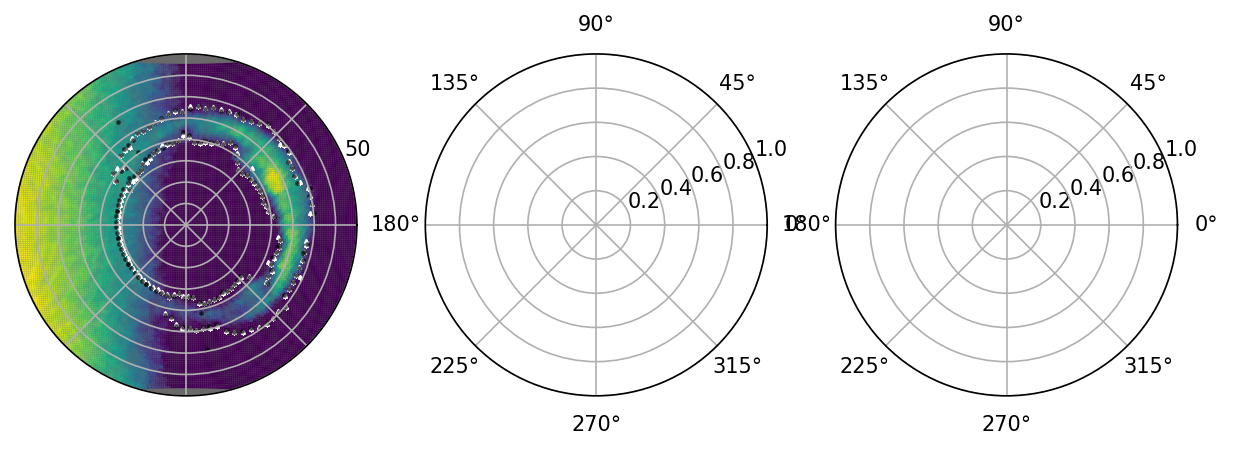

In [181]:
import matplotlib

ks = 1

fig = plt.figure(figsize=[10,4])
gs = GridSpec(1,3)


ax1 = fig.add_subplot(gs[0,0],projection='polar')
ax2 = fig.add_subplot(gs[0,1],projection='polar')
ax3 = fig.add_subplot(gs[0,2],projection='polar')

ax1, _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::ks],d['LAT_VERTS'][:,::ks],d['LON_VERTS'][:,::ks],norm=norm, ax=ax1)
cb.remove()
ax1.scatter(np.deg2rad(lon_n),lat_n,2, color='white', marker='^')
ax1.scatter(np.deg2rad(lon_m),lat_m,2, color='black', alpha=0.5)
ax1.scatter(np.deg2rad(lond_n),latd_n,2, color='white', marker='^')
ax1.scatter(np.deg2rad(lond_m),latd_m,2, color='black', alpha=0.5)
ax1.set_rlim(90,50)
_ = ax1.set_xticklabels([])
_ = ax1.set_yticklabels([50])

gdu_m = np.where((lon_m > 270) | (lon_m < 90))
gdd_m =np.where((lond_m > 270) | (lond_m < 90))

p_t = np.deg2rad(np.array([lon_m[gdu_m[0]],lond_m[gdd_m[0]]])).reshape(-1)
p_r = np.array([lat_m[gdu_m[0]],latd_m[gdd_m[0]]]).reshape(-1)

#polygon = matplotlib.patches.Polygon(np.array([p_t,p_r]).swapaxes(0,1),fill=False)
#ax1.add_patch(polygon)


In [177]:
p_r

array([69.31720424, 70.19671548, 70.50068862, 71.14764867, 70.89358395,
       70.85432769, 71.18779375, 71.14240844, 71.57754235, 71.50676527,
       72.10066777, 72.22610377, 71.06333158, 69.75156825, 68.33298833,
       68.0336732 , 69.08125305, 69.25120739, 69.60635984, 69.86822184,
       70.41500113, 70.4659261 , 68.94030655, 73.04831433, 73.05444931,
       71.75932487, 71.02135302, 71.04998132, 71.39386301, 71.48028463,
       72.27631689, 71.69365978, 71.74887124, 72.19492459, 72.46260559,
       72.56825074, 70.92518316, 66.67985903, 67.42898591, 67.5252943 ,
       68.0644522 , 68.40320392, 68.07090408, 67.56526314, 67.72373561,
       68.17707443, 69.06495706, 59.90879654, 60.20297712, 60.43386672,
       59.77806033, 62.29735581, 62.15549069, 61.74059668, 61.89206287,
       60.51435317, 60.23314178, 60.20740654, 59.92117157, 59.56102519,
       60.68047993, 61.37480499, 61.89388472, 61.45831733, 61.77513334,
       62.07961609, 62.01808783, 62.45681512, 62.12854716, 62.77

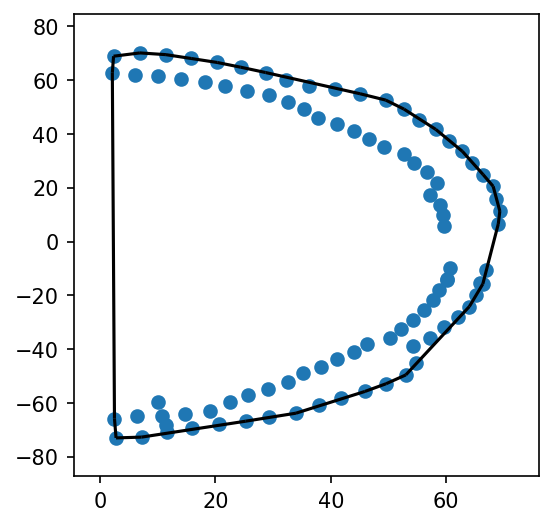

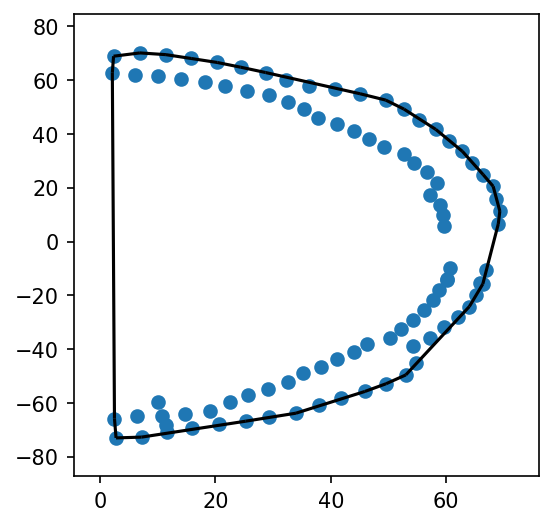

In [179]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

fig = plt.figure(figsize=[4,4])
gs = GridSpec(1,1)

xx = p_r*np.cos(p_t)
yy = p_r*np.sin(p_t) 

ax1 = fig.add_subplot(gs[0,0])


hull = ConvexHull(np.array([xx,yy]).swapaxes(0,1))

convex_hull_plot_2d(hull, ax=ax1)

In [171]:
hull.vertices

array([ 0, 47, 50, 59, 83, 91, 44, 35, 24, 23, 11, 10,  3,  1],
      dtype=int32)

In [163]:
polygon = matplotlib.patches.Polygon(np.array([p_t,p_r]).swapaxes(0,1),fill=False)

In [141]:
gdu_m = np.where((lond_m > 270) | (lond_m < 90))

In [56]:
mlt = 10.125
np.abs(mlt-dat[1]['cir_lon']/15).argmin()

39

In [ ]:
np.abs(dat[1]['lats'][:-1]-dat[4]['lats']).mean()
np.abs(dat[1]['lats'][:-1]-dat[4]['lats']).max()
np.abs(dat[1]['lats'][:-1]-dat[4]['lats']).min()


In [ ]:
ax1.set_t

In [ ]:
sig[idx]

In [ ]:
ax, p_col, c_bar = dpl.guvi_plot(d['IM'][i_st].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm)

In [ ]:
a = np.where(scn_x > 0)

In [ ]:
plt.plot(scn_m,im_s)

In [ ]:
from skimage import feature

In [ ]:
d['LAT_ARR'][i_st].shape

In [ ]:
lat_v = d['LAT_ARR'][i_st][104,:].copy()
lon_v = d['LON_ARR'][i_st][104,:].copy()

y_v = (90-(np.array(lat_v)))*np.sin(np.deg2rad(lon_v))
y_c = np.argsort(y_v)
plt.plot(y_v)

In [ ]:
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese


lat_v = d['LAT_ARR'][i_st][104,:].copy()
lon_v = d['LON_ARR'][i_st][104,:].copy()

y_v = (90-(np.array(lat_v)))*np.sin(np.deg2rad(lon_v))
y_c = np.argsort(y_v)

image = d['IM'][i_st][:,y_c]
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(
    image,
    mu=0.25,
    lambda1=1,
    lambda2=1,
    tol=1e-3,
    max_num_iter=200,
    dt=0.5,
    init_level_set="checkerboard",
    extended_output=True,
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [ ]:
plt.plot(cv[1][:,50])
plt.plot(cv[1][:,125])

In [ ]:
plt.imshow(cv[1], vmin=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import skimage as ski


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = cv[1]

# Initial level set
init_ls = ski.segmentation.checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = ski.segmentation.morphological_chan_vese(
    image, num_iter=35, init_level_set=init_ls, smoothing=3, iter_callback=callback
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Morphological ACWE evolution", fontsize=12)

contour_labels = []
for n, color in ((2, 'g'), (7, 'y'), (35, 'r')):
    ax[1].contour(evolution[n], [0.5], colors=color)

    # Use empty line to represent this contour in the legend
    legend_line = mlines.Line2D([], [], color=color, label=f"Iteration {n}")
    contour_labels.append(legend_line)

ax[1].legend(handles=contour_labels, loc="upper right")

# Morphological GAC
image = cv[1]
gimage = ski.segmentation.inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = ski.segmentation.morphological_geodesic_active_contour(
    gimage,
    num_iter=230,
    init_level_set=init_ls,
    smoothing=1,
    balloon=-1,
    threshold=0.69,
    iter_callback=callback,
)

ax[2].imshow(image, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray")
ax[3].set_axis_off()
ax[3].set_title("Morphological GAC evolution", fontsize=12)

contour_labels = []
for n, color in ((0, 'g'), (100, 'y'), (230, 'r')):
    ax[3].contour(evolution[n], [0.5], colors=color)

    # Use empty line to represent this contour in the legend
    legend_line = mlines.Line2D([], [], color=color, label=f"Iteration {n}")
    contour_labels.append(legend_line)

ax[3].legend(handles=contour_labels, loc="upper right")

fig.tight_layout()
plt.show()

In [ ]:
plt.imshow(im[5,:,0:84])

In [ ]:
%%timeit

for slc_f, slc_d in zip(imf.transpose(), im0.transpose()):
    id_nan = idx[~slc_f]
    id_fin = idx[slc_f]
    for id in id_nan:
        id_close = np.abs(id_fin-id).argmin() 
        slc_d[id] = slc_d[id_fin[id_close]]
    

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(d['IM'][-40],vmin=1000,vmax=10000)

In [ ]:
import matplotlib.colors as cols
norm = cols.LogNorm()
cmap=plt.cm.inferno

In [ ]:
guvi_plot(im0,d['LAT_VERTS'],d['LON_VERTS'])

In [ ]:
guvi_plot(d['IM'][0],d['LAT_VERTS'],d['LON_VERTS'])

In [ ]:
d.keys()
d['LAT_ARR'].shape

In [ ]:
plt.plot(im0[105:-1,100])
plt.plot(im0[0:105,100])